In [67]:
import sys
import os
import pandas as pd
import copy

# Add the parent directory of the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))

In [68]:
from transformers import AutoTokenizer
from benchmark_workload_gen import ToolBenchDataLoader, LoadDistribution

num_workloads = 100
num_requests = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
dataloader = ToolBenchDataLoader('datasets/G1_workload_updated_input_output_lengths_4096_cropped_to_50.json', num_workloads, num_requests, tokenizer, LoadDistribution.EVEN)

In [69]:
workload = dataloader.generate_workload(k=1.1)

4000


In [210]:
import re
def get_tool(workload_item):
    text = workload_item["text"]
    match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if match:
        tool = match.group(1)
        return tool
get_tool(workload[0]), get_tool(workload[1])

('latest_stock_price', 'ca_boundaries_io')

In [211]:
import heapq
import time
from collections import defaultdict
from dataclasses import dataclass
from typing import Tuple
from uuid import uuid4  

import torch

class TreeNode:
    def __init__(self):
        self.id = uuid4()  
        self.children = defaultdict(TreeNode)
        self.parent = None
        self.value = None
        self.ref_counter = 0
        self.last_access_time = time.time()
        self.gpu_selections = set()

    @property
    def num_tokens(self):
        return len(self.value)
        
    def __lt__(self, other):
        return self.last_access_time < other.last_access_time
    
    def __eq__(self, other):
        if isinstance(other, TreeNode):
            return self.id == other.id  # Compare nodes based on their unique ID
        return False

    def __hash__(self):
        return hash(self.id)  # Use the unique ID for hashing

    def __repr__(self) -> str:
        return f"TreeNode(id={self.id}, ref_counter={self.ref_counter})"

def match(key, seq):
    i = 0
    for k, w in zip(key, seq):
        if k != w:
            break
        i += 1
    return i


class RadixCache:
    def __init__(self, disable=False):
        self.reset()
        self.disable = disable

    ##### Public API #####

    def reset(self):
        self.root_node = TreeNode()
        self.root_node.value = []
        self.root_node.ref_counter = 1
        self.evictable_size_ = 0

    def find_node(self, key):
        if self.disable:
            return None
        current_gpu_selection, node = self.match_prefix_get_gpu_selection(key)
        return node

    def match_prefix_get_gpu_selection(self, key):
        if self.disable:
            return [], self.root_node

        value = []
        current_gpu_selection = self.root_node.gpu_selections
        current_gpu_selection, node = self._match_prefix_helper_gpu_selection(self.root_node, key, value, current_gpu_selection)
        return current_gpu_selection, node

    def _match_prefix_helper_gpu_selection(self, node, key, value, current_gpu_selection):
        node.last_access_time = time.time()
        child: TreeNode
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)
            if prefix_len != 0:
                text = tokenizer.decode(child.value)
                if child.gpu_selections:
                    current_gpu_selection = child.gpu_selections
                if prefix_len < len(c_key):
                    assert False
                    new_node = self._split_node(c_key, child, prefix_len, new_nodes_created=new_nodes_created)
                    value.append(new_node.value)
                    # last_node[0] = new_node
                else:
                    value.append(child.value)
                    # last_node[0] = child
                    return self._match_prefix_helper_gpu_selection(child, key[prefix_len:], value, current_gpu_selection)
        return current_gpu_selection, node

    def match_prefix_return_str(self, key):
        return "".join(self.match_prefix(key)[0])

    def insert(self, key, value=None, node_map=None, all_modified_nodes=None, split_nodes=None, depth_limit=0):
        if node_map is None:
            node_map = {}
            print("Node map is None")
        if split_nodes is None:
            split_nodes = {} # key -> node
        if self.disable:
            return len(key)

        if value is None:
            value = [x for x in key]
        modified_nodes = set()
        total_tokens_added = self._insert_helper(
            self.root_node,
            key, 
            value, 
            node_map=node_map, 
            modified_nodes=modified_nodes, 
            depth_limit=depth_limit, 
            current_depth=0,
            split_nodes=split_nodes
        )

        node: TreeNode
        for node in modified_nodes:
            # Add all parents till parent is none to all_modified_nodes
            while node is not None:
                all_modified_nodes.add(node)
                node = node.parent
        return total_tokens_added

    def pretty_print(self):
        self._print_helper(self.root_node, 0)
        print(f"#tokens: {self.total_size()}")

    def total_size(self):
        return self._total_size_helper(self.root_node)

    def evict(self, num_tokens, evict_callback):
        if self.disable:
            raise RuntimeError()

        leaves = self._collect_leaves()
        heapq.heapify(leaves)

        num_evicted = 0
        while num_evicted < num_tokens and len(leaves):
            x = heapq.heappop(leaves)

            if x == self.root_node:
                break
            if x.ref_counter > 0:
                continue

            num_evicted += evict_callback(x.value)
            self._delete_leaf(x)

            if len(x.parent.children) == 0:
                heapq.heappush(leaves, x.parent)

    def inc_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 0:
                self.evictable_size_ -= len(node.value)
                delta -= len(node.value)
            node.ref_counter += 1
            node = node.parent
        return delta

    def dec_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 1:
                self.evictable_size_ += len(node.value)
                delta += len(node.value)
            node.ref_counter -= 1
            node = node.parent
        return delta

    def remove_completed_input_ids(self, input_ids):
        node = self.find_node(input_ids)
        self.dec_ref_counter(node) # remove reference counter up to parent

    def evictable_size(self):
        return self.evictable_size_

    def _split_node(self, key, child, split_len, node_map, depth_limit, current_depth):
        # new_node -> child
        new_node = TreeNode()
        new_node.gpu_selections = copy.deepcopy(child.gpu_selections)
        new_node.children = {
            key[split_len:]: child
        }
        new_node.parent = child.parent
        new_node.ref_counter = child.ref_counter

        new_node.value = child.value[:split_len]
        child.parent = new_node
        child.value = child.value[split_len:]

        new_node.parent.children[key[:split_len]] = new_node
        del new_node.parent.children[key]

        # if child in node_map and current_depth < depth_limit:
        #     node_map[new_node] = node_map[child]

        return new_node

    def _insert_helper(self, node, key, value, node_map, modified_nodes, depth_limit, current_depth, split_nodes):
        node.last_access_time = time.time()
        node.ref_counter += 1
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)

            if prefix_len == len(c_key):
                if prefix_len == len(key):
                    child.ref_counter += 1
                    return prefix_len
                else:
                    key = key[prefix_len:]
                    value = value[prefix_len:]
                    return prefix_len + self._insert_helper(child, key, value, node_map=node_map, modified_nodes=modified_nodes, depth_limit=depth_limit, current_depth=current_depth + 1, split_nodes=split_nodes)

            if prefix_len:
                new_node = self._split_node(c_key, child, prefix_len, node_map, depth_limit=depth_limit, current_depth=current_depth + 1)
                modified_nodes.add(new_node)
                modified_nodes.add(child)
                if child in node_map and current_depth < depth_limit:
                    split_nodes[child] = new_node
                return prefix_len + self._insert_helper(
                    new_node, key[prefix_len:], value[prefix_len:], node_map=node_map, modified_nodes=modified_nodes, depth_limit=depth_limit, current_depth=current_depth + 1, split_nodes=split_nodes
                )

        if len(key):
            new_node = TreeNode()
            new_node.gpu_selections = copy.deepcopy(node.gpu_selections)
            new_node.parent = node
            new_node.value = value
            new_node.ref_counter = 1
            node.children[key] = new_node
            self.evictable_size_ += len(value)
            if current_depth < depth_limit:
                modified_nodes.add(new_node)
        return 0

    
    def _print_helper(self, node, indent, depth=0):
        if depth == 5:
            return
        for key, child in node.children.items():
            print(" " * indent, len(key), key[:10], f"r={child.ref_counter}")
            self._print_helper(child, indent=indent + 2, depth=depth + 1)
        

    def _delete_leaf(self, node):
        for k, v in node.parent.children.items():
            if v == node:
                break
        del node.parent.children[k]
        self.evictable_size_ -= len(k)

    def _total_size_helper(self, node):
        x = len(node.value)
        for child in node.children.values():
            x += self._total_size_helper(child)
        return x

    def _collect_leaves(self):
        ret_list = []

        def dfs_(cur_node):
            if len(cur_node.children) == 0:
                ret_list.append(cur_node)

            for x in cur_node.children.values():
                dfs_(x)

        dfs_(self.root_node)
        return ret_list


In [216]:
import time
from mip import Model, xsum, BINARY, MINIMIZE, OptimizationStatus, minimize, INTEGER, GUROBI, CONTINUOUS
import random
from typing import Optional

class LpNode:
    def __init__(self, node_id, num_gpus):
        self.node_id = node_id
        self.variables = [None for _ in range(num_gpus)]  # Will be initialized as binary variables in the model
        self.children_token_cost_at_max_depth = 0 # Issue is that depth_limit will cut off the tokens for children and that will treat it as free
        self.randomly_selected_gpu = None
        self.load_variables = [None for _ in range(num_gpus)]
        self.common_load = None
    
    def __repr__(self):
        variable_values = [var.x if var else None for var in self.variables]
        load_variable_values = [var.x if var else None for var in self.load_variables]
        common_load = self.common_load.x if self.common_load else None
        # ignore printing laod variables if None
        if any(load_variable_values):
            return f"LpNode(node_id={self.node_id}, variables={variable_values}, load_variables={load_variable_values}, common_load={common_load})"
        else:
            return f"LpNode(node_id={self.node_id}, variables={variable_values})"

class LPTreeTraversal:
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.node_map = {}  # Maps PrefixTreeNode to LpNode
        self.depth_limit = 5
        self.model = Model(sense=MINIMIZE, solver_name=GUROBI)
        self.model.verbose = 1
        self.counter = 0
        self.total_cost_var = None
        self.per_gpu_constraints = []
        self.dynamic_constraints = []  # To keep track of dynamic constraints
        self.iteration_counter = 0 

    def init_lp_node(self, prefix_node, is_leaf):
        # if prefix_node in self.node_map:
        #     return self.node_map[prefix_node] # TODO fixme. I need to handle splitting of nodes
        current_lp_node = LpNode(prefix_node.id, self.num_gpus)
        self.node_map[prefix_node] = current_lp_node
        # Initialize binary variables for the LP node
        for gpu in range(self.num_gpus):
            current_lp_node.variables[gpu] = self.model.add_var(f"x_{prefix_node.id}_{gpu}",var_type=BINARY)
            if is_leaf:
                current_lp_node.load_variables[gpu] = self.model.add_var(f"l_{prefix_node.id}_{gpu}",var_type=CONTINUOUS)
        if is_leaf:
            current_lp_node.common_load = self.model.add_var(f"l_avg_{prefix_node.id}",var_type=CONTINUOUS,lb=0)
        return current_lp_node


    def _traverse_tree(self, current_prefix_node: TreeNode, parent_lp_node: Optional[LpNode]=None, depth=0, modified_nodes=None):
        if modified_nodes is not None and current_prefix_node not in modified_nodes:
            return # Skip nodes that have not been modified

        if depth == self.depth_limit:
            assert parent_lp_node is not None
            parent_lp_node.children_token_cost_at_max_depth = self._calculate_children_token_cost(current_prefix_node)
            return

        current_lp_node = self.init_lp_node(current_prefix_node, not current_prefix_node.children or depth + 1 == self.depth_limit)

        # At least one GPU must be allocated for a prefix
        self.model += xsum(current_lp_node.variables) >= 1

        if parent_lp_node:
            # If the child takes a node, then the parent must also take a node
            for gpu in range(self.num_gpus):
                self.model += current_lp_node.variables[gpu] <= parent_lp_node.variables[gpu]

        for child_prefix_node in current_prefix_node.children.values():
            self._traverse_tree(current_prefix_node=child_prefix_node, parent_lp_node=current_lp_node, depth=depth + 1, modified_nodes=modified_nodes)

    def _calculate_children_token_cost(self, node: TreeNode):
        """
        Recursively calculate the total number of tokens for all children of a given node,
        effectively aggregating the tokens for nodes that are beyond the depth limit.
        """
        if node is None:
            return 0
        total_tokens = node.num_tokens
        for child in node.children.values():
            total_tokens += self._calculate_children_token_cost(child)
        return total_tokens

    def add_parent_child_gpu_constraints(self, modified_nodes=None):
        for parent_prefix_node, parent_lp_node in self.node_map.items():
            if modified_nodes is not None and parent_prefix_node not in modified_nodes:
                continue
            if not parent_prefix_node.children:  # Skip leaf nodes
                continue
            for gpu_index in range(self.num_gpus):
                children_gpu_selections = []
                for child_prefix_node in parent_prefix_node.children.values():
                    if child_prefix_node in self.node_map:
                        child_lp_node = self.node_map[child_prefix_node]
                        children_gpu_selections.append(child_lp_node.variables[gpu_index])
                if children_gpu_selections:
                    children_selections_total = xsum(children_gpu_selections)
                    self.model += parent_lp_node.variables[gpu_index] <= children_selections_total
    
    def traverse_and_optimize(self, prefix_tree_root, existing_cost={}, modified_nodes=None, objective_only=False):
        if modified_nodes is None:
            modified_nodes = set()
        start_time = time.time()

        self._traverse_tree(prefix_tree_root, modified_nodes=modified_nodes)  # Set up variables and base constraints
        self.add_parent_child_gpu_constraints(modified_nodes=modified_nodes)  # Add parent-child constraints

        # Objective components: Let's assume we're trying to minimize the total cost adjusted for existing costs
        total_cost = []
        per_gpu_load_cost = [[] for _ in range(self.num_gpus)]
        initial_solution = []
        for prefix_node, lp_node in self.node_map.items():
            num_tokens_total = prefix_node.num_tokens + lp_node.children_token_cost_at_max_depth
            for gpu_index, var in enumerate(lp_node.variables):
                previous_gpu_selected = existing_cost.get(prefix_node, {}).get(gpu_index, 0) 
                if previous_gpu_selected:
                    initial_solution.append((var, previous_gpu_selected))
                mistral_tokens_to_prefill_time = lambda x: 0.148 * x + 22.7
                num_tokens_time = mistral_tokens_to_prefill_time(num_tokens_total)
                
                decode_length  = 16 # for now assume decoding occurs for 20 tokens
                decoding_time = lambda x: 6.7 * x
                total_cost.append(var * num_tokens_time - var * previous_gpu_selected * num_tokens_time)
                # per_gpu_mem_cost[gpu_index].append(var * num_tokens_time)

                if  lp_node.load_variables[gpu_index]:
                    self.model += lp_node.load_variables[gpu_index] >= var * prefix_node.ref_counter / self.num_gpus
                    self.model += lp_node.load_variables[gpu_index] <= var * 1000000
                    self.model += lp_node.load_variables[gpu_index] <= lp_node.common_load + 1000000 * (1 - var)
                    self.model += lp_node.load_variables[gpu_index] >= lp_node.common_load - 1000000 * (1 - var)
                    load_cost = lp_node.load_variables[gpu_index] * decoding_time(decode_length)
                    per_gpu_load_cost[gpu_index].append(load_cost)
            if any(lp_node.load_variables):
                self.model += xsum(lp_node.load_variables) >= prefix_node.ref_counter

        self.max_per_gpu_cost = self.model.add_var(name=f"max_per_gpu_cost", var_type=INTEGER)
        # self.total_gpu_load_cost = [xsum(load_cost) for load_cost in per_gpu_load_cost]
        for item in per_gpu_load_cost:
            current_gpu_cost = xsum(item)
            constraint = self.model.add_constr(current_gpu_cost <= self.max_per_gpu_cost)

        # self.per_gpu_constraints = per_gpu_constraints
        self.model.start = initial_solution
        self.model.threads = -1
        # self.model.max_mip_gap = 0.02
        self.model.max_seconds = 0.2
        setup_time = time.time() - start_time
        solving_time = time.time()

        self.model.objective = minimize(xsum(total_cost) + self.max_per_gpu_cost)

        status = self.model.optimize()

        # print(f"max cost per gpu {self.max_per_gpu_cost.x} {self.total_cost_var.x}")
        tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
        print(f"Objective value: {self.model.objective_value}")
        # print(f"Total GPU Cost: {self.max_per_gpu_cost.x} Mem cost {self.model.objective_value - self.max_per_gpu_cost.x}")

        if status == OptimizationStatus.OPTIMAL:
            pass
            # print('Optimal solution found.')
        elif status == OptimizationStatus.FEASIBLE:
            print('Feasible solution found, but not necessarily optimal.')
        else:
            print('No feasible solution found.')
        print(f"Solving time: {time.time() - solving_time}s Setup Time {setup_time}s Tota")

    def get_exisiting_cost(self, split_nodes={}):
        existing_cost = {}
        lp_node: LpNode
        for prefix_node, lp_node in self.node_map.items():
            for gpu_id, var in enumerate(lp_node.variables):
                if prefix_node not in existing_cost:
                    existing_cost[prefix_node] = {}
                solver_selection = var and var.x >= 0.99
                random_selection = lp_node.randomly_selected_gpu and lp_node.randomly_selected_gpu == gpu_id
                if solver_selection or random_selection:
                    existing_cost[prefix_node][gpu_id] = 1
                else:
                    existing_cost[prefix_node][gpu_id] = 0
        if split_nodes:   
            # When a tree splits ths existing cost should be preserved
            for node_id, new_node_id in split_nodes.items():
                existing_cost[new_node_id] = existing_cost[node_id]
        return existing_cost

    def calculate_tokens_per_gpu(self):
        tokens_per_gpu = {gpu: 0 for gpu in range(self.num_gpus)}  # Reset/initialize
        load_to_gpu = {gpu: 0 for gpu in range(self.num_gpus)}
        lp_node:LpNode
        # pretty print node map
        print("Node Map", self.node_map)
        import pprint
        pp = pprint.PrettyPrinter(depth=4)
        pp.pprint(self.node_map)
        for prefix_node, lp_node in self.node_map.items():
            for i, var in enumerate(lp_node.variables):

                solved_var = var.x if var.x >= 0.99 else 0
                if solved_var:  # If GPU i is selected by this node, using .x for variable value in MIP
                    tokens_per_gpu[i] += prefix_node.num_tokens  # Accumulate tokens
                    load_to_gpu[i] += prefix_node.ref_counter
        return tokens_per_gpu, load_to_gpu

    def pretty_print(self, prefix_node):
        self.pretty_print_helper(prefix_node)

    def pretty_print_helper(self, prefix_node, indent="", depth=0):
        if depth == self.depth_limit:
            return
        lp_node = self.node_map.get(prefix_node)
        if lp_node:
            if lp_node.randomly_selected_gpu:
                selected_gpus = [lp_node.randomly_selected_gpu]
            else:
                selected_gpus = [i for i, var in enumerate(lp_node.variables) if var and var.x >= 0.99]  # Adjust threshold as needed, using .x for variable value
            def get_tool(workload_item):
                text = tokenizer.decode(workload_item)
                if ":" in text:
                    return text.split(":")[0].strip().replace("\n", " ")
                else:
                    return text[:60].strip().replace("\n", "")
            print(f"{indent}Node {lp_node.node_id} (Tokens: {get_tool(prefix_node.value)}, {len(prefix_node.value)}): GPUs {selected_gpus}")
        else:
            print(f"{indent}Node (Prefix: {len(prefix_node.value)}) has no LP Node mapping")

        for child in prefix_node.children.values():
            self.pretty_print_helper(child, indent + "  ", depth=depth + 1)

    def update_nodes_with_solution(self, modified_nodes=None):
        for prefix_node, lp_node in self.node_map.items():
            prefix_node.gpu_selections = set()
            for gpu_id, var in enumerate(lp_node.variables):
                if var.x >= 0.99:
                    prefix_node.gpu_selections.add(gpu_id)

class LPScheduler:
    def __init__(self, num_nodes: int, depth_limit=4, update_interval=5):
        self.num_nodes = num_nodes
        self.tree_cache = RadixCache()
        self.shadow_cache = RadixCache()
        self.lp_tree_traversal = LPTreeTraversal(num_nodes)
        self.lp_tree_traversal.depth_limit = depth_limit
        self.metrics_dict = []
        self.counter = 0
        self.update_interval=update_interval
        self.load = {

        }
        self.modified_nodes = set()

    def runtime_selector(self, text: str=None, request_id: str=None, input_ids=None, ):
        # Tokenize the text
        start_time = time.time()

        node_map = self.lp_tree_traversal.node_map
        self.tree_cache.insert(tuple(input_ids), node_map=node_map, all_modified_nodes=self.modified_nodes, depth_limit=self.lp_tree_traversal.depth_limit)
        if self.counter % self.update_interval == 0:
            existing_cost = self.lp_tree_traversal.get_exisiting_cost()
            self.lp_tree_traversal.traverse_and_optimize(self.tree_cache.root_node, existing_cost=existing_cost, modified_nodes=self.modified_nodes)
            self.lp_tree_traversal.update_nodes_with_solution()
            self.modified_nodes = set()

        self.counter += 1
        gpu_selections, node = self.tree_cache.match_prefix_get_gpu_selection(input_ids)
        # Randomly select a node from gpu selections
        mode = "not_random"
        if len(gpu_selections) == 0 or len(gpu_selections) == self.num_nodes:
            print("Random selection", gpu_selections)
            gpu_selections = set(range(self.num_nodes))
            mode = "random"

        runtime_selected = random.choice(list(gpu_selections))
        self.load[runtime_selected] = self.load.get(runtime_selected, 0) + 1
        self.metrics_dict.append({
            "text": text,
            "rid": request_id,
            "selected_runtime": runtime_selected,
            "overhead": time.time() - start_time,
            "mode": mode
        })
        return runtime_selected

# Example usage (you would need to define the structure of PrefixTreeNode and provide a valid prefix_tree_root):


In [217]:
lorem_ipsum = """
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Sit amet purus gravida quis blandit turpis cursus. Sagittis nisl rhoncus mattis rhoncus urna neque viverra justo. Sapien et ligula ullamcorper malesuada proin libero nunc consequat. Sed velit dignissim sodales ut eu sem integer. Nulla aliquet enim tortor at auctor urna nunc id. Nulla aliquet enim tortor at auctor urna nunc id cursus. Tortor at risus viverra adipiscing at in tellus. Consequat nisl vel pretium lectus quam id. Rutrum quisque non tellus orci ac auctor. Natoque penatibus et magnis dis parturient.

Nunc sed velit dignissim sodales ut eu sem integer. Sit amet consectetur adipiscing elit pellentesque. Lectus nulla at volutpat diam ut venenatis tellus in. Rhoncus mattis rhoncus urna neque viverra. A lacus vestibulum sed arcu non odio euismod lacinia at. Sem fringilla ut morbi tincidunt augue interdum velit. Massa ultricies mi quis hendrerit dolor magna eget. Mus mauris vitae ultricies leo. Aliquam purus sit amet luctus venenatis lectus magna. Ac feugiat sed lectus vestibulum mattis ullamcorper velit.

Fringilla ut morbi tincidunt augue interdum. Tincidunt nunc pulvinar sapien et ligula ullamcorper. Consequat mauris nunc congue nisi vitae suscipit tellus mauris. Erat nam at lectus urna duis convallis convallis. Mauris nunc congue nisi vitae suscipit tellus mauris. Blandit massa enim nec dui nunc mattis enim. Velit dignissim sodales ut eu sem integer vitae. Semper viverra nam libero justo laoreet sit amet cursus sit. Urna condimentum mattis pellentesque id nibh tortor id aliquet. Dui nunc mattis enim ut tellus elementum sagittis. Facilisi nullam vehicula ipsum a arcu cursus vitae congue mauris. Aenean vel elit scelerisque mauris. Amet nulla facilisi morbi tempus iaculis. Nec feugiat nisl pretium fusce id velit ut tortor. Amet justo donec enim diam vulputate ut pharetra. Turpis cursus in hac habitasse platea. At auctor urna nunc id cursus metus.

Auctor elit sed vulputate mi sit amet mauris. Rhoncus mattis rhoncus urna neque viverra justo. Cursus euismod quis viverra nibh cras pulvinar mattis nunc sed. Aliquam faucibus purus in massa tempor. Felis eget nunc lobortis mattis aliquam faucibus. Ullamcorper malesuada proin libero nunc consequat interdum varius. Vulputate eu scelerisque felis imperdiet proin fermentum leo vel. Mi ipsum faucibus vitae aliquet nec ullamcorper sit amet risus. Habitasse platea dictumst quisque sagittis purus sit amet. Felis eget velit aliquet sagittis id consectetur purus. Odio eu feugiat pretium nibh ipsum consequat. Laoreet non curabitur gravida arcu ac tortor dignissim. Mi in nulla posuere sollicitudin aliquam ultrices sagittis orci a. Molestie a iaculis at erat. Enim diam vulputate ut pharetra. Eu non diam phasellus vestibulum lorem sed.

Scelerisque fermentum dui faucibus in ornare. Ut tellus elementum sagittis vitae et leo. Felis eget nunc lobortis mattis aliquam faucibus purus in massa. Amet tellus cras adipiscing enim eu turpis egestas. Dignissim enim sit amet venenatis urna cursus eget nunc scelerisque. Nisi lacus sed viverra tellus in hac. Nulla malesuada pellentesque elit eget. Purus in massa tempor nec feugiat nisl pretium fusce. Lectus nulla at volutpat diam ut venenatis tellus in. Neque ornare aenean euismod elementum nisi quis eleifend. Enim praesent elementum facilisis leo vel.
"""

In [218]:
import random
print(f"Workload length: {len(workload)}")
lp_tree_traversal = LPTreeTraversal(2)
lp_tree_traversal.depth_limit = 4
runtime_selected = []
texts = ["Workload  1 ABCD"] # , "A Different Workload ABCD" + lorem_ipsum
# for i in range(5):
#     texts += ["Workload  1 ABCD" + lorem_ipsum, "A Different Workload ABCD" + lorem_ipsum]

# for i in range(5):
#      texts += ["Workload  1 ABCD" + lorem_ipsum, "Workload 2 ABCD" + lorem_ipsum]

# for j in range(25):
#      texts += ["Workload  1 ABCD" + lorem_ipsum, "Workload 2 ABCD" + lorem_ipsum]
texts = ["Workload  1 ABCD " + lorem_ipsum, "Workload 2 ABCD" + lorem_ipsum] # , "A Different Workload ABCD" + lorem_ipsum
# for i in range(5):
#     texts += ["Workload  1 ABCD" + lorem_ipsum, "A Different Workload ABCD" + lorem_ipsum]

for i in range(10):
     texts += ["Workload  1 ABCD " + lorem_ipsum]
cache = RadixCache()
# texts = ["1 sentence. A B C D", "3 sentence. A B C D", "4 sentencee. A B C D", "2 sentence. A B C D", "1 sentence. A B C D example 1", "1 sentence example 2", "2 sentence. A B C D E"]
input_ids = [tokenizer.encode(text) for text in texts]
modified_nodes = set()
for i in range(len(texts)):
    print(f"Request {i}")
    node_map = lp_tree_traversal.node_map
    split_nodes = {}
    from pprint import pprint
    pprint(node_map)
    cache.insert(tuple(input_ids[i]), node_map=node_map, all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit, split_nodes=split_nodes)

    cache.pretty_print()
#     modified_nodes = None
    existing_cost = lp_tree_traversal.get_exisiting_cost(split_nodes=split_nodes)
    runtime = lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=existing_cost, modified_nodes=modified_nodes)
    tokens_per_gpu, load_to_gpu = lp_tree_traversal.calculate_tokens_per_gpu()
    print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
    lp_tree_traversal.update_nodes_with_solution()
    lp_tree_traversal.pretty_print(cache.root_node)
    modified_nodes = set()
    # break

# scheduler = LPScheduler(2)
# for i in range(4):
#     print(f"Request {i}")
#     cache.insert(tuple(input_ids[i]))
#     runtime_selected = scheduler.runtime_selector(text=texts[i], request_id=i, input_ids=input_ids[i])
#     print(texts[i],runtime_selected)


Workload length: 4000
Set parameter Username
Request 0
{}
 1233 (1, 5066, 1768, 259, 28740, 22673, 28757, 28705, 13, 28758) r=1
#tokens: 1233
Node Map {TreeNode(id=e2132e75-73ce-4e61-945b-98864c021fcd, ref_counter=2): LpNode(node_id=e2132e75-73ce-4e61-945b-98864c021fcd, variables=[0.0, 1.0]), TreeNode(id=efff0a2d-296f-4a15-8590-d1be26681bd1, ref_counter=1): LpNode(node_id=efff0a2d-296f-4a15-8590-d1be26681bd1, variables=[0.0, 1.0], load_variables=[0.0, 1.0], common_load=1.0)}
{TreeNode(id=e2132e75-73ce-4e61-945b-98864c021fcd, ref_counter=2): LpNode(node_id=e2132e75-73ce-4e61-945b-98864c021fcd, variables=[0.0, 1.0]),
 TreeNode(id=efff0a2d-296f-4a15-8590-d1be26681bd1, ref_counter=1): LpNode(node_id=efff0a2d-296f-4a15-8590-d1be26681bd1, variables=[0.0, 1.0], load_variables=[0.0, 1.0], common_load=1.0)}
Tokens per GPU: {0: 0, 1: 1233} {0: 0, 1: 3}
Objective value: 335.88399999999996
Solving time: 0.004860401153564453s Setup Time 0.0004162788391113281s Tota
Node Map {TreeNode(id=e2132e75-73c

In [ ]:
import random
print(f"Workload length: {len(workload)}")

runtime_selected = []

cache = RadixCache()
scheduler = LPScheduler(2, depth_limit=3, update_interval=1)

# input_ids = [tokenizer.encode(text) for text in texts]
# for i in range(len(texts)):
#     runtime = scheduler.runtime_selector(input_ids=input_ids[i], text=texts[i])
#     scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
#     runtime_selected.append(runtime)
workload_0 = workload[0]
additional = []
for i in range(20):
    additional.append(workload_0)
modified_nodes = set()
for i in workload[:50] + additional:
    # lp_tree_traversal = lp_tree_traversal = LPTreeTraversal(2)
    # lp_tree_traversal.depth_limit = 3
    # print(f"Request {i}")
    node_map = lp_tree_traversal.node_map
    input_ids = i["input_ids"]
    cache.insert(tuple(input_ids), node_map=node_map, all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit)

    cache.pretty_print()
    print("MODIFIED NODES", [x.id for x in modified_nodes])
    existing_cost = lp_tree_traversal.get_exisiting_cost()
    modified_nodes = None
    runtime = lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=existing_cost, modified_nodes=modified_nodes)
    # tokens_per_gpu, load_to_gpu = lp_tree_traversal.calculate_tokens_per_gpu()
    # print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
    # lp_tree_traversal.update_nodes_with_solution()
    lp_tree_traversal.pretty_print(cache.root_node)
    modified_nodes = set()
    # break
    # runtime = scheduler.runtime_selector(input_ids=i["input_ids"], text=i["text"])
    # scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
    # runtime_selected.append(runtime)

print(pd.DataFrame(scheduler.metrics_dict))
# Write metrics dict to json
import json
with open("metrics_lp_scheduler_2_200.json", "w") as f:
    json.dump(scheduler.metrics_dict, f)


Workload length: 4000
Set parameter Username
 2549 (1, 2135, 28747, 995, 460, 12191, 28777, 6316, 28725, 368) r=1
#tokens: 2549
MODIFIED NODES [UUID('6fc6240d-c28b-4ecf-bee1-00cb0a436161'), UUID('b74c1bb1-ebe6-48d7-812f-85362f903d41')]
Node Map {TreeNode(id=c0532962-4eef-4853-98c1-352c500cadf1, ref_counter=7): LpNode(node_id=c0532962-4eef-4853-98c1-352c500cadf1, variables=[1.0, 1.0]), TreeNode(id=041c34fc-18a9-487b-a889-2ab7cb26c6df, ref_counter=3): LpNode(node_id=041c34fc-18a9-487b-a889-2ab7cb26c6df, variables=[0.0, 1.0], load_variables=[0.0, 3.0], common_load=3.0), TreeNode(id=7aa577b2-691b-4d72-a2c4-b2a6eafbe37d, ref_counter=6): LpNode(node_id=7aa577b2-691b-4d72-a2c4-b2a6eafbe37d, variables=[1.0, 1.0]), TreeNode(id=352a698f-32f3-4b94-b3dc-36e41b75320f, ref_counter=3): LpNode(node_id=352a698f-32f3-4b94-b3dc-36e41b75320f, variables=[1.0, 0.0], load_variables=[3.0, 0.0], common_load=3.0)}
{TreeNode(id=041c34fc-18a9-487b-a889-2ab7cb26c6df, ref_counter=3): LpNode(node_id=041c34fc-18a9-48

In [23]:
# workload[0]
# import sys
# sys.setrecursionlimit(300)  # Increase the maximum recursion depth to 3000

# Debug Random workload

In [ ]:
from transformers import AutoTokenizer
from benchmark_workload_gen import RandomDataLoader

num_workloads = 100
num_requests = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
dataloader = RandomDataLoader(4, total_num_requests=num_requests, tokenizer=tokenizer, load_dist=LoadDistribution.EVEN, random_workload_path="datasets/ShareGPT_V3_unfiltered_cleaned_split.json")

# from benchmark_workload_gen import LooGLEDataset, LooGLEDatasetType
# dataloader_short = LooGLEDataset(
#     loogle_dataset_type=LooGLEDatasetType.SHORT_QA, 
#     num_patterns=4, 
#     total_num_requests=100, 
#     tokenizer=tokenizer, 
#     load_dist=LoadDistribution.ALL, 
#     crop_max_decode=True)
# workload_short = dataloader_short.generate_workload(max_length=32000)

In [ ]:
workload = dataloader.generate_workload(k=1.1)

In [ ]:
import random
print(f"Workload length: {len(workload)}")
scheduler = LPScheduler(2, depth_limit=3, update_interval=1)
runtime_selected = []

for i in workload[:200]:
    runtime = scheduler.runtime_selector(input_ids=i["input_ids"], text=i["text"])
    # scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
    runtime_selected.append(runtime)

print(pd.DataFrame(scheduler.metrics_dict))
# Write metrics dict to json
import json
with open("metrics_lp_scheduler_2_200.json", "w") as f:
    json.dump(scheduler.metrics_dict, f)


In [ ]:
import pandas as pd

def measure_acc(df, num_nodes=4):
    # Create a pivot table from the dataframe
    pivot_table = df.pivot_table(index='text', columns='selected_runtime', aggfunc='size', fill_value=0)

    # Dynamically rename columns based on num_nodes
    pivot_table.columns = [f'selected_runtime_{i}' for i in range(num_nodes)]

    # Print the pivot table for verification
    print(pivot_table)

    # Save the pivot table to a CSV file
    pivot_table.to_csv("pivot_table.csv")

    correct = 0
    # Iterate over each row to count 'correct' selections
    for index, row in pivot_table.iterrows():
        # Print the index for verification
        # print(f"Index: {index}")
        
        # Count the number of columns with non-zero values (indicating a selection was made)
        num_selected = sum(row[f'selected_runtime_{i}'] != 0 for i in range(num_nodes))
        
        # If exactly one runtime was selected, consider it 'correct'
        if num_selected == 1:
            correct += 1

    total = len(pivot_table)
    accuracy = correct / total if total > 0 else 0  # Compute accuracy, guarding against division by zero

    # Print the results
    print(f"Correct: {correct} Total: {total}")
    print(f"Accuracy: {accuracy}")

# Assuming 'df' is your DataFrame containing the job scheduling results
# measure_acc(df
import re 
df = pd.DataFrame(scheduler.metrics_dict)
def get_tool(x):
    text = x
    match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if match:
        tool = match.group(1)
        return tool
    return text
print(df)
df["text"] = df["text"].map(lambda x: get_tool(x))

df.to_csv("test.csv")
measure_acc(df, num_nodes=2)

# Visualize Time required

In [ ]:
times = []
# interval = 100
depth_limit = 3
lp_tree_traversal = LPTreeTraversal(2)
lp_tree_traversal.depth_limit = depth_limit
cache = RadixCache()
random.shuffle(workload)
modified_nodes = set()
prev_existing_cost = {}
split_nodes = {}
for item in workload[:1000]:
    cache.insert(tuple(item["input_ids"]), all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit, split_nodes=split_nodes, node_map=lp_tree_traversal.node_map)

lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost(split_nodes), modified_nodes=modified_nodes)
lp_tree_traversal.update_nodes_with_solution()
# lp_tree_traversal.pretty_print(cache.root_node)
modified_nodes = set()

for i in range(1000):
    # for item in workload[i*interval:(i+1)*interval]:
    #     cache.insert(tuple(item["input_ids"]), all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit)
    start_time = time.time()
    time_after_inserting = time.time()
    lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost(), modified_nodes=modified_nodes, objective_only=True)
    # lp_tree_traversal.update_nodes_with_solution()
    existing_cost = lp_tree_traversal.get_exisiting_cost()
    total_new_nodes_in_existing_cost = len(existing_cost) - len(prev_existing_cost)
    prev_existing_cost = existing_cost
    times.append({"num_nodes": len(lp_tree_traversal.node_map), "time_after_inserting": time.time() - time_after_inserting, "total": i, "depth_limit": depth_limit, "num_modified": len(modified_nodes)})
    modified_nodes = set()


In [ ]:
len(lp_tree_traversal.node_map)

In [ ]:
time_df = pd.DataFrame(times)
time_df


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

time_df = pd.DataFrame(times)

# Assuming time_df is your DataFrame
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for subplots

# Plot on the first subplot
time_df.plot(ax=axs[0], x="total", y="time_after_inserting", title="Time taken vs Total", marker='o', linestyle='-')
axs[0].set_xlabel("Total")
axs[0].set_ylabel("Time (seconds)")

# Plot on the second subplot
time_df.plot(ax=axs[1], x="num_nodes", y="time_after_inserting", title="Time taken vs Number of Nodes", marker='o', linestyle='-')
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("Time (seconds)")

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load JSON data
file_name = 'metrics_lp_scheduler_2_200.json'
with open(file_name, 'r') as file:
    data = json.load(file)

# Extract overhead values
overhead_values = [entry['overhead'] for entry in data]
max_index = np.argmax(overhead_values)
max_value = overhead_values[max_index]
print("Index with max overhead:", max_index)
print("Value with max overhead:", max_value)

std_dev = np.std(overhead_values) / 4  # Reduced for visualization purposes
error = [std_dev] * len(overhead_values)
# Initial Plot
plt.figure(figsize=(10, 6))
plt.plot(overhead_values, marker='o', linestyle='-', color='b')
plt.title('Overhead over Time for depth = 3')
plt.xlabel('Time (sequential order of metrics)')
plt.ylabel('Overhead (seconds)')
plt.grid(True)
# plt.savefig('initial_overhead_plot.png')
# plt.close()
plt.show()
# More Smoothed Plot
more_smoothed_overhead = savgol_filter(overhead_values, 21, 3)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(overhead_values)), more_smoothed_overhead, yerr=error, marker='o', linestyle='-', color='g', ecolor='lightgray', elinewidth=3, capsize=0)
plt.title('More Smoothed Overhead over Time with Error Bars')
plt.xlabel('Time (sequential order of metrics)')
plt.ylabel('Overhead (seconds)')
plt.grid(True)
# plt.savefig('more_smoothed_overhead_with_error_bars.png')
# plt.close()
plt.show()



# %%
# Initialize a dictionary to map the first 10 characters to the selected runtime
runtime_selection = {}
correct_predictions = 0
ignore_items = 0
import re

for entry in data:
    text = entry['text']
    matched_tool = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if matched_tool:
        tool = matched_tool.group(1)
    first_10_chars = tool
    selected_runtime = entry['selected_runtime']
    # If the first 10 characters have been seen before
    if first_10_chars in runtime_selection:
        # Check if the selected runtime matches the previously recorded runtime
        if runtime_selection[first_10_chars] == selected_runtime:
            correct_predictions += 1
        else:
            print(f"Incorrect prediction for tool: {first_10_chars}")
    else:
        # Record the runtime selection for the first 10 characters
        runtime_selection[first_10_chars] = selected_runtime
        # Assuming the first selection is always correct as there's no precedent
        correct_predictions += 1

# Calculate the accuracy
accuracy_percentage = (correct_predictions / (len(data) - ignore_items)) * 100
accuracy_percentage

# LP Gurobi Version

In [203]:

from gurobipy import GRB
import gurobipy as gp
from collections import defaultdict

class LPGurobiTreeTraversal:
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.node_map = {}
        self.depth_limit = 5
        # Create a new model. Gurobi doesn't use a solver_name argument; it automatically selects the best solver.
        self.model = gp.Model("LPTreeTraversal")
        self.model.setParam('OutputFlag', 0)  # Equivalent to verbose = 1 in python-mip
        self.model.setParam('LogToConsole', 0)
        self.total_cost_var = None
        self.per_gpu_constraints = []
        self.iteration_counter = 0 
        self.all_node_constraints = defaultdict(list)
        self.max_per_gpu_cost = self.model.addVar(name="max_per_gpu_cost", vtype=GRB.INTEGER)
        self.max_per_gpu_cost_constr = []
        self.existing_constraints = {}

    def init_load_vars(self, prefix_node: TreeNode, lp_node: LpNode, is_leaf: bool):
        if not is_leaf:
            return
        for gpu in range(self.num_gpus):
            lp_node.load_variables[gpu] = self.model.addVar(vtype=GRB.CONTINUOUS, name=f"l_{prefix_node.id}_{gpu}")
        lp_node.common_load = self.model.addVar(vtype=GRB.CONTINUOUS, name=f"l_avg_{prefix_node.id}", lb=0)

    def init_lp_node(self, prefix_node, is_leaf):
        if prefix_node not in self.node_map:
            lp_node = LpNode(prefix_node.id, self.num_gpus)
            self.node_map[prefix_node] = lp_node
            for gpu in range(self.num_gpus):
                lp_node.variables[gpu] = self.model.addVar(vtype=GRB.BINARY, name=f"x_{prefix_node.id}_{gpu}")
        lp_node = self.node_map[prefix_node]
        self.init_load_vars(prefix_node, lp_node, is_leaf)
        return lp_node

        # self.init_load_vars(current_lp_node, is_leaf)
        # # Initialize binary variables for the LP node

        # for gpu in range(self.num_gpus):
        #     current_lp_node.variables[gpu] = self.model.addVar(vtype=GRB.BINARY, name=f"x_{prefix_node.id}_{gpu}")
        #     if is_leaf:
        #         current_lp_node.load_variables[gpu] = self.model.addVar(vtype=GRB.CONTINUOUS, name=f"l_{prefix_node.id}_{gpu}")
        # if is_leaf:
        #     current_lp_node.common_load = self.model.addVar(vtype=GRB.CONTINUOUS, name=f"l_avg_{prefix_node.id}", lb=0)
        # return current_lp_node

    def _traverse_tree(self, current_prefix_node: TreeNode, parent_lp_node: Optional[LpNode]=None, depth=0, modified_nodes=None):
        if modified_nodes is not None and current_prefix_node not in modified_nodes:
            return  # Skip nodes that have not been modified

        if depth == self.depth_limit:
            assert parent_lp_node is not None
            parent_lp_node.children_token_cost_at_max_depth = self._calculate_children_token_cost(current_prefix_node)
            return
        
        is_leaf = not current_prefix_node.children or depth + 1 == self.depth_limit
        current_lp_node = self.init_lp_node(current_prefix_node, is_leaf)

        # At least one GPU must be allocated for a prefix, with a unique constraint name
        constraint_name = f"alloc_at_least_one_gpu_{current_prefix_node.id}"
        constr = self.model.addConstr(gp.quicksum(current_lp_node.variables) >= 1, name=constraint_name)
        self.all_node_constraints[current_prefix_node.id].append(constr)

        if is_leaf:        
            # Constrain the load on all the nodes
            for gpu_index in range(self.num_gpus):
                var = current_lp_node.variables[gpu_index]
                assert current_lp_node.load_variables[gpu_index] is not None
                load_lower_constr = self.model.addConstr(current_lp_node.load_variables[gpu_index] >= var * current_prefix_node.ref_counter / self.num_gpus, name=f"load_var_{current_prefix_node.id}_{gpu_index}_lower")
                load_upper_constr = self.model.addConstr(current_lp_node.load_variables[gpu_index] <= var * 1000000, name=f"load_var_{current_prefix_node.id}_{gpu_index}_upper")
                avg_load_upper_constr = self.model.addConstr(current_lp_node.load_variables[gpu_index] <= current_lp_node.common_load + 1000000 * (1 - var), name=f"load_var_{current_prefix_node.id}_{gpu_index}_common_load_upper")
                avg_load_lower_constr = self.model.addConstr(current_lp_node.load_variables[gpu_index] >= current_lp_node.common_load - 1000000 * (1 - var), name=f"load_var_{current_prefix_node.id}_{gpu_index}_common_load_lower")
                self.all_node_constraints[current_prefix_node.id].extend([load_lower_constr, load_upper_constr, avg_load_upper_constr, avg_load_lower_constr])
            if any(current_lp_node.load_variables):
                constr = self.model.addConstr(gp.quicksum(current_lp_node.load_variables) >= current_prefix_node.ref_counter, name=f"load_constr_sum_{current_prefix_node.id}")
                self.all_node_constraints[current_prefix_node.id].append(constr)

        if parent_lp_node:
            # If the child takes a node, then the parent must also take a node, with unique constraint names for each GPU
            for gpu in range(self.num_gpus):
                constraint_name = f"parent_child_gpu_alloc_{current_lp_node.node_id}_{parent_lp_node.node_id}_{gpu}"
                constr = self.model.addConstr(current_lp_node.variables[gpu] <= parent_lp_node.variables[gpu], name=constraint_name)
                self.all_node_constraints[current_prefix_node.id].append(constr)
        for child_prefix_node in current_prefix_node.children.values():
            self._traverse_tree(current_prefix_node=child_prefix_node, parent_lp_node=current_lp_node, depth=depth + 1, modified_nodes=modified_nodes)


    def add_parent_child_gpu_constraints(self, modified_nodes=None):
        for parent_prefix_node, parent_lp_node in self.node_map.items():
            if modified_nodes is not None and parent_prefix_node not in modified_nodes:
                continue
            for gpu_index in range(self.num_gpus):
                children_gpu_selections = []
                for child_prefix_node in parent_prefix_node.children.values():
                    if child_prefix_node in self.node_map:
                        child_lp_node = self.node_map[child_prefix_node]
                        children_gpu_selections.append(child_lp_node.variables[gpu_index])
                if children_gpu_selections:
                    # Use Gurobi's quicksum for summing up the selections
                    children_selections_total = gp.quicksum(children_gpu_selections)
                    # Create a constraint with a unique name for easy identification
                    constraint_name = f"parent_{parent_lp_node.node_id}_gpu_{gpu_index}_children_selection"
                    constr = self.model.addConstr(parent_lp_node.variables[gpu_index] <= children_selections_total, name=constraint_name)
                    self.all_node_constraints[parent_prefix_node.id].append(constr)

    # def add_parent_child_gpu_constraints_recursively(self, current_node, gpu_assignment_variables=None, depth=0):
    #     if gpu_assignment_variables is None:
    #         gpu_assignment_variables = {gpu_index: [] for gpu_index in range(self.num_gpus)}
        
    #     if depth == self.depth_limit:
    #         return gpu_assignment_variables

    #     if current_node not in modified_nodes:
    #         return gpu_assignment_variables

    #     # Base case: if the current node has no children, return the GPU assignment variables for the current node
    #     if not current_node.children:
    #         for gpu_index in range(self.num_gpus):
    #             gpu_assignment_variables[gpu_index].append(self.node_map[current_node].variables[gpu_index])
    #         return gpu_assignment_variables

    #     # Recursive case: accumulate GPU assignment variables from children
    #     for child in current_node.children.values():
    #         child_gpu_assignments = self.add_parent_child_gpu_constraints_recursively(child, gpu_assignment_variables, depth=depth+1)

    #     # After collecting assignments from children, apply constraints for the current node
    #     for gpu_index in range(self.num_gpus):
    #         if current_node in self.node_map:  # Check if current node is in the LP model
    #             current_lp_node = self.node_map[current_node]
    #             # Sum children GPU assignments for the current GPU
    #             children_selections_total = gp.quicksum(child_gpu_assignments[gpu_index])
    #             # Add constraint for the current node on the current GPU
    #             constraint_name = f"parent_{current_lp_node.node_id}_gpu_{gpu_index}_children_selection"
    #             constr = self.model.addConstr(current_lp_node.variables[gpu_index] <= children_selections_total, name=constraint_name)
    #             self.all_node_constraints[current_node.id].append(constr)
    #     return gpu_assignment_variables

    def traverse_and_optimize(self, prefix_tree_root, previous_cost={}, modified_nodes=None, objective_only=False):
        start_time = time.time()
        
        for node in modified_nodes:
            for constr in self.all_node_constraints[node.id]:
                self.model.remove(constr)
            self.all_node_constraints[node.id] = []
        
        for constr in self.max_per_gpu_cost_constr:
            self.model.remove(constr)
        
        self.max_per_gpu_cost_constr = []

        self._traverse_tree(prefix_tree_root, modified_nodes=modified_nodes)  # Set up variables and base constraints
        constraint_removal_time2 = time.time() - start_time
        
        start_time = time.time()
        self.add_parent_child_gpu_constraints(modified_nodes=modified_nodes)  # Add parent-child constraints
        # self.add_parent_child_gpu_constraints_recursively(prefix_tree_root)
        constraint_removal_time = time.time() - start_time

        start_time = time.time()

        # Objective components: Let's assume we're trying to minimize the total cost adjusted for existing costs
        total_cost = gp.LinExpr()
        per_gpu_load_cost = [gp.LinExpr() for _ in range(self.num_gpus)]
        initial_solution = []
        for prefix_node, lp_node in self.node_map.items():
            num_tokens_total = prefix_node.num_tokens + lp_node.children_token_cost_at_max_depth
            for gpu_index, var in enumerate(lp_node.variables):
                previous_gpu_selected = previous_cost['placement_cost'].get(prefix_node, {}).get(gpu_index, 0)
                if previous_gpu_selected:
                    var.Start = previous_gpu_selected  # Set initial solution
                mistral_tokens_to_prefill_time = lambda x: 0.148 * x + 22.7
                num_tokens_time = mistral_tokens_to_prefill_time(num_tokens_total)
                
                decode_length = 16  # Assume decoding occurs for 20 tokens
                decoding_time = lambda x: 6.7 * x
                total_cost += var * (num_tokens_time - previous_gpu_selected * num_tokens_time)

                if lp_node.load_variables[gpu_index]:
                    load_cost = lp_node.load_variables[gpu_index] * decoding_time(decode_length) 
                    per_gpu_load_cost[gpu_index] += load_cost
                    # per_gpu_load_cost[gpu_index] += var * decoding_time(decode_length)

        for gpu_id, item in enumerate(per_gpu_load_cost):
            constr = self.model.addConstr(item <= self.max_per_gpu_cost, name=f"max_per_gpu_cost_constr_{gpu_id}")
            self.max_per_gpu_cost_constr.append(constr)
    
        # Set objective
        setup_time = time.time() - start_time
        self.model.setObjective(total_cost + self.max_per_gpu_cost, GRB.MINIMIZE)

        # Model parameters
        self.model.setParam('Threads', 0)
        self.model.setParam('TimeLimit', 0.05)
        self.model.setParam('MIPGap', 0.02)

        solving_start_time = time.time()
        self.model.optimize()
        solving_time = time.time() - solving_start_time


        if self.model.Status == GRB.OPTIMAL:
            print('Optimal solution found.')
        elif self.model.Status == GRB.INFEASIBLE:
            print('Infeasable solution found')

        else:
            print('Feasible solution found.')

        # tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        # print(f"Tokens per GPU: {tokens_per_gpu}, Load to GPU: {load_to_gpu}")
        # print(f"Objective value: {self.model.ObjVal}")
        # 
        # To get the total number of variables in the model
        num_vars = self.model.numVars

        # To get the total number of constraints in the model
        num_constraints = self.model.numConstrs

        # Print total number of parameters (variables and constraints)
        # print(f"Total number of variables: {num_vars}")
        # print(f"Total number of constraints: {num_constraints}")

        print(f"Solving time: {solving_time}s, Setup Time: {setup_time}s Total constraint_removal_time {constraint_removal_time}s, {constraint_removal_time2} modified nodes len {len(modified_nodes)}, {num_vars}, {num_constraints}")
        return time.time() - start_time

    def get_previous_cost(self, split_nodes={}):
        placement_cost = {}
        load_cost = {}
        for prefix_node, lp_node in self.node_map.items():
            load_cost[prefix_node] = {}
            placement_cost[prefix_node] = {}
            for gpu_id, var in enumerate(lp_node.variables):
                # Initialize a nested dictionary if the prefix node hasn't been encountered yet
                # Check if the variable was selected by the solver or randomly, for Gurobi use var.X to get the solution value
                solver_selection = var and var.X >= 0.99  # Gurobi uses var.X to access the value of a variable
                random_selection = lp_node.randomly_selected_gpu is not None and lp_node.randomly_selected_gpu == gpu_id
                if solver_selection or random_selection:
                    placement_cost[prefix_node][gpu_id] = 1
                else:
                    placement_cost[prefix_node][gpu_id] = 0
                if lp_node.load_variables[gpu_id]:
                    load_cost[prefix_node][gpu_id] = lp_node.load_variables[gpu_id].X

        # Handle split nodes by preserving the existing cost across the split
        if split_nodes:
            for node_id, new_node_id in split_nodes.items():
                if node_id in placement_cost:
                    placement_cost[new_node_id] = placement_cost[node_id]
        return {
            "placement_cost": placement_cost,
            "load_cost": load_cost
        }

    def _calculate_children_token_cost(self, node: TreeNode):
        """
        Recursively calculate the total number of tokens for all children of a given node,
        effectively aggregating the tokens for nodes that are beyond the depth limit.
        """
        if node is None:
            return 0
        total_tokens = node.num_tokens
        for child in node.children.values():
            total_tokens += self._calculate_children_token_cost(child)
        return total_tokens

    def calculate_tokens_per_gpu(self):
        tokens_per_gpu = {gpu: 0 for gpu in range(self.num_gpus)}  # Reset/initialize
        load_to_gpu = {gpu: 0 for gpu in range(self.num_gpus)}
        lp_node:LpNode
        # pretty print node map
        for prefix_node, lp_node in self.node_map.items():
            for i, var in enumerate(lp_node.variables):
                solved_var = var.X if var.X >= 0.99 else 0
                if solved_var:  # If GPU i is selected by this node, using .x for variable value in MIP
                    tokens_per_gpu[i] += prefix_node.num_tokens  # Accumulate tokens
                    load_to_gpu[i] += prefix_node.ref_counter
        return tokens_per_gpu, load_to_gpu

    def pretty_print(self, prefix_node):
        self.pretty_print_helper(prefix_node)

    def pretty_print(self, prefix_node):
        self.pretty_print_helper(prefix_node)

    def pretty_print_helper(self, prefix_node, indent="", depth=0):
        if depth == self.depth_limit:
            return
        lp_node = self.node_map.get(prefix_node)
        if lp_node:
            if lp_node.randomly_selected_gpu:
                selected_gpus = [lp_node.randomly_selected_gpu]
            else:
                selected_gpus = [i for i, var in enumerate(lp_node.variables) if var and var.X >= 0.99]  # Adjust threshold as needed, using .x for variable value
            def get_tool(workload_item):
                text = tokenizer.decode(workload_item)
                if ":" in text:
                    return text.split(":")[0].strip().replace("\n", " ")
                else:
                    return text[:60].strip().replace("\n", "")
            print(f"{indent}Node {lp_node.node_id} (Tokens: {get_tool(prefix_node.value)}, {len(prefix_node.value)}): GPUs {selected_gpus}")
        else:
            print(f"{indent}Node (Prefix: {len(prefix_node.value)}) has no LP Node mapping")

        for child in prefix_node.children.values():
            self.pretty_print_helper(child, indent + "  ", depth=depth + 1)

    def update_nodes_with_solution(self, modified_nodes=None):
        for prefix_node, lp_node in self.node_map.items():
            prefix_node.gpu_selections = set()
            for gpu_id, var in enumerate(lp_node.variables):
                if var.X>= 0.99:
                    prefix_node.gpu_selections.add(gpu_id)

class GurobiLPScheduler:
    def __init__(self, num_nodes: int, depth_limit=4, update_interval=5):
        self.num_nodes = num_nodes
        self.tree_cache = RadixCache()
        self.shadow_cache = RadixCache()
        self.lp_tree_traversal = LPGurobiTreeTraversal(num_nodes)
        self.lp_tree_traversal.depth_limit = depth_limit
        self.metrics_dict = []
        self.counter = 0
        self.update_interval=update_interval
        self.load = {

        }
        self.modified_nodes = set()

    def runtime_selector(self, text: str=None, request_id: str=None, input_ids=None, ):
        # Tokenize the text
        start_time = time.time()

        node_map = self.lp_tree_traversal.node_map
        split_nodes = {}
        self.tree_cache.insert(tuple(input_ids), node_map=node_map, all_modified_nodes=self.modified_nodes, depth_limit=self.lp_tree_traversal.depth_limit, split_nodes=split_nodes)
        existing_cost = self.lp_tree_traversal.get_exisiting_cost(split_nodes)
        self.lp_tree_traversal.traverse_and_optimize(self.tree_cache.root_node, existing_cost=existing_cost, modified_nodes=self.modified_nodes)
        self.lp_tree_traversal.update_nodes_with_solution()
        self.modified_nodes = set()

        self.counter += 1
        gpu_selections, node = self.tree_cache.match_prefix_get_gpu_selection(input_ids)
        # Randomly select a node from gpu selections
        mode = "not_random"
        if len(gpu_selections) == 0 or len(gpu_selections) == self.num_nodes:
            print("Random selection", gpu_selections)
            gpu_selections = set(range(self.num_nodes))
            mode = "random"

        runtime_selected = random.choice(list(gpu_selections))
        self.load[runtime_selected] = self.load.get(runtime_selected, 0) + 1
        self.metrics_dict.append({
            "text": text,
            "rid": request_id,
            "selected_runtime": runtime_selected,
            "overhead": time.time() - start_time,
            "mode": mode
        })
        return runtime_selected


In [209]:
import random
print(f"Workload length: {len(workload)}")
lp_tree_traversal = LPGurobiTreeTraversal(2)
lp_tree_traversal.depth_limit = 3
runtime_selected = []
texts = ["Workload  1 ABCD " + lorem_ipsum, "Workload 2 ABCD" + lorem_ipsum] # , "A Different Workload ABCD" + lorem_ipsum
# for i in range(5):
#     texts += ["Workload  1 ABCD" + lorem_ipsum, "A Different Workload ABCD" + lorem_ipsum]

for i in range(5):
     texts += ["Workload  1 ABCD " + lorem_ipsum]

# for i in range(5):
#     texts += ["Workload  1 ABCD " + lorem_ipsum]

cache = RadixCache()
# texts = ["1 sentence. A B C D", "3 sentence. A B C D", "4 sentencee. A B C D", "2 sentence. A B C D", "1 sentence. A B C D example 1", "1 sentence example 2", "2 sentence. A B C D E"]
input_ids = [tokenizer.encode(text) for text in texts]
modified_nodes = set()
for i in range(len(texts)):
    print(f"Request {i}")
    node_map = lp_tree_traversal.node_map
    split_nodes = {}
    from pprint import pprint
    cache.insert(tuple(input_ids[i]), node_map=node_map, all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit, split_nodes=split_nodes)
    cache.pretty_print()
#     modified_nodes = None
    existing_cost = lp_tree_traversal.get_previous_cost(split_nodes=split_nodes)
    runtime = lp_tree_traversal.traverse_and_optimize(cache.root_node, previous_cost=existing_cost, modified_nodes=modified_nodes)
    tokens_per_gpu, load_to_gpu = lp_tree_traversal.calculate_tokens_per_gpu()
    print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
    lp_tree_traversal.update_nodes_with_solution()
    lp_tree_traversal.pretty_print(cache.root_node)
    modified_nodes = set()
    # break

# scheduler = LPScheduler(2)
# for i in range(4):
#     print(f"Request {i}")
#     cache.insert(tuple(input_ids[i]))
#     runtime_selected = scheduler.runtime_selector(text=texts[i], request_id=i, input_ids=input_ids[i])
#     print(texts[i],runtime_selected)


Workload length: 4000
Request 0
 1233 (1, 5066, 1768, 259, 28740, 22673, 28757, 28705, 13, 28758) r=1
#tokens: 1233
Optimal solution found.
Solving time: 0.02230238914489746s, Setup Time: 3.361701965332031e-05s Total constraint_removal_time 3.361701965332031e-05s, 0.0003399848937988281 modified nodes len 2, 8, 17
Tokens per GPU: {0: 0, 1: 1233} {0: 0, 1: 3}
Node 5c06a6e7-634a-4c1b-9f09-e434f80b6706 (Tokens: , 0): GPUs [1]
  Node d545abe5-8833-46df-b4c5-6b0ffbba7a52 (Tokens: <s> Workload  1 ABCD Lorem ipsum dolor sit amet, consectetu, 1233): GPUs [1]
Request 1
 3 (1, 5066, 1768) r=2
   1230 (259, 28740, 22673, 28757, 28705, 13, 28758, 5382, 8465, 1801) r=1
   1229 (28705, 28750, 22673, 28757, 13, 28758, 5382, 8465, 1801, 13824) r=1
#tokens: 2462
Optimal solution found.
Solving time: 0.0049664974212646484s, Setup Time: 0.00011205673217773438s Total constraint_removal_time 0.00014662742614746094s, 0.0011334419250488281 modified nodes len 4, 18, 34
Tokens per GPU: {0: 1232, 1: 1233} {0: 6,

In [189]:
times = []
# interval = 100
depth_limit = 3
lp_tree_traversal = LPGurobiTreeTraversal(2)
lp_tree_traversal.depth_limit = depth_limit
cache = RadixCache()
workload2 = workload + workload
random.shuffle(workload)
modified_nodes = set()
prev_existing_cost = {}
split_nodes = {}
# lp_tree_traversal.pretty_print(cache.root_node)
interval = 1
for i in range(4000):
    for item in workload[i*interval:(i+1)*interval]:
        cache.insert(tuple(item["input_ids"]), all_modified_nodes=modified_nodes, depth_limit=lp_tree_traversal.depth_limit, split_nodes=split_nodes, node_map=lp_tree_traversal.node_map)
    start_time = time.time()
    time_after_inserting = time.time()
    total_time = lp_tree_traversal.traverse_and_optimize(cache.root_node, previous_cost=lp_tree_traversal.get_previous_cost(split_nodes=split_nodes), modified_nodes=modified_nodes)
    lp_tree_traversal.update_nodes_with_solution()
    prev_existing_cost = existing_cost
    times.append({"num_nodes": len(lp_tree_traversal.node_map), "time_after_inserting": total_time, "total": i, "depth_limit": depth_limit, "num_modified": len(modified_nodes), "workloadlen": len(workload[i*interval:(i+1)*interval])})
    modified_nodes = set()
    split_nodes = {}
    print(f"Root GPU Selection", cache.root_node.gpu_selections)
    # lp_tree_traversal.pretty_print(cache.root_node)

    # remove load from 20 requests back
    # if i > 50:
    #     for item in workload[(i-50)*interval:(i-50)*interval]:
    #         cache.remove_completed_input_ids(tuple(item["input_ids"]))
    # assert(cache.root_node.gpu_selections == set([0, 1]))

Optimal solution found.
Solving time: 0.02450251579284668s, Setup Time: 3.886222839355469e-05s Total constraint_removal_time 3.337860107421875e-05s, 0.0003170967102050781 modified nodes len 2, 8, 17
Root GPU Selection {1}
Optimal solution found.
Solving time: 0.004953145980834961s, Setup Time: 0.00010967254638671875s Total constraint_removal_time 0.00011014938354492188s, 0.0010037422180175781 modified nodes len 4, 18, 34
Root GPU Selection {0, 1}
Optimal solution found.
Solving time: 0.002395153045654297s, Setup Time: 8.559226989746094e-05s Total constraint_removal_time 7.700920104980469e-05s, 0.00037384033203125 modified nodes len 3, 23, 46
Root GPU Selection {0, 1}
Optimal solution found.
Solving time: 0.0038628578186035156s, Setup Time: 9.703636169433594e-05s Total constraint_removal_time 8.0108642578125e-05s, 0.0003707408905029297 modified nodes len 3, 28, 58
Root GPU Selection {0, 1}
Optimal solution found.
Solving time: 0.006669759750366211s, Setup Time: 8.96453857421875e-05s Tot

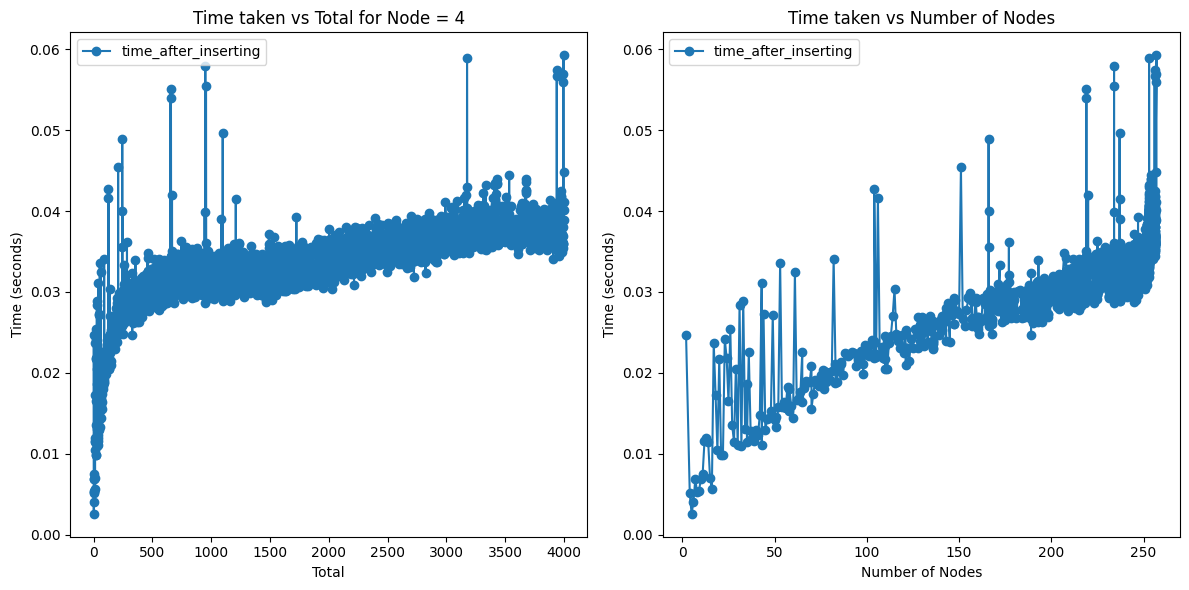

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

time_df = pd.DataFrame(times)

# Assuming time_df is your DataFrame
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for subplots

# Plot on the first subplot
time_df.plot(ax=axs[0], x="total", y="time_after_inserting", title="Time taken vs Total for Node = 4", marker='o', linestyle='-')
axs[0].set_xlabel("Total")
axs[0].set_ylabel("Time (seconds)")

# Plot on the second subplot
time_df.plot(ax=axs[1], x="num_nodes", y="time_after_inserting", title="Time taken vs Number of Nodes", marker='o', linestyle='-')
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("Time (seconds)")

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()


In [191]:
(time_df["time_after_inserting"].argmax()), time_df["time_after_inserting"].max() * 1000

(3995, 59.27538871765137)

In [192]:
lp_tree_traversal.pretty_print(cache.root_node)

Node 46d8084d-3f4c-437c-ab65-af4072a55940 (Tokens: , 0): GPUs [0, 1]
  Node 0bf173ec-3088-4c83-8126-bfab05d24f73 (Tokens: <s> System, 358): GPUs [0, 1]
    Node 422b41dc-cbca-432c-9741-28f499b6855f (Tokens: c, 1): GPUs [1]
    Node 6f201a90-943e-48b2-a009-c9d93d9c8b10 (Tokens: f, 1): GPUs [1]
    Node d829d684-9a7e-4dfb-b763-e3a0aa917c3b (Tokens: bing_video_search, 580): GPUs [0]
    Node ac880295-59ee-4d59-9932-eeadd36188f5 (Tokens: mocktwitter, 375): GPUs [0]
    Node 25fe4924-b2f2-415b-834f-3379a512168b (Tokens: z, 1): GPUs [1]
    Node 6e1890dd-fc0a-4512-9f1d-db0a5a7b9bdb (Tokens: m, 1): GPUs [1]
    Node 780eab49-cbaf-4db9-a3c2-e2cae7e5ab83 (Tokens: dogbreeds, 227): GPUs [1]
    Node b30a5770-1061-4a7f-bbed-7877b0eeeacd (Tokens: news_network, 747): GPUs [0]
    Node 1e6caa9a-0017-4beb-b9bc-07e9e433e355 (Tokens: demo_project_v2, 137): GPUs [1]
    Node 3beaa4b4-bcb4-4c33-b892-50d96aa58e32 (Tokens: us, 1): GPUs [0]
    Node be4b798f-897d-4abe-a964-4930c9e3ee24 (Tokens: get_27coupons

In [ ]:
for item in lp_tree_traversal.model.getConstrs():
    if "818c1074-440c-44f1-b85e-4329847decf7" in item.ConstrName:
        print(item.ConstrName)

# for item in lp_tree_traversal.model.getConstrs():
#     if "alloc_at_least_one_gpu_43b9dfd3-4432-45b2-a131-ae0b695d13d4" in item.ConstrName:
#         print(item.ConstrName)

In [460]:
lp_tree_traversal.node_map


{TreeNode(id=2efe8570-39de-4a62-b71b-70880b23d524, ref_counter=1423): LpNode(node_id=2efe8570-39de-4a62-b71b-70880b23d524, variables=[1.0, 0.0]),
 TreeNode(id=818c1074-440c-44f1-b85e-4329847decf7, ref_counter=1422): LpNode(node_id=818c1074-440c-44f1-b85e-4329847decf7, variables=[1.0, 0.0]),
 TreeNode(id=c047099e-3795-47f9-8fee-f2665897c983, ref_counter=1): LpNode(node_id=c047099e-3795-47f9-8fee-f2665897c983, variables=[1.0, 0.0]),
 TreeNode(id=641d3ecf-e704-443e-8cdc-a45e015f8ccb, ref_counter=1): LpNode(node_id=641d3ecf-e704-443e-8cdc-a45e015f8ccb, variables=[0.0, 0.0]),
 TreeNode(id=c708c3fc-9034-4ceb-a11d-11d734d2d805, ref_counter=1): LpNode(node_id=c708c3fc-9034-4ceb-a11d-11d734d2d805, variables=[0.0, 0.0]),
 TreeNode(id=80e45d33-bf9f-46a8-843c-ab49ef525b6c, ref_counter=1): LpNode(node_id=80e45d33-bf9f-46a8-843c-ab49ef525b6c, variables=[0.0, 1.0]),
 TreeNode(id=e70a3d13-5869-4ae2-8546-38f192c5424d, ref_counter=1): LpNode(node_id=e70a3d13-5869-4ae2-8546-38f192c5424d, variables=[0.0, 